# Workflow for each state point

In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
from IPython.display import Image

The workflow represented in this notebook has these steps:

simulate --> compute_squared_displacements --> compute_mean_squared_displacement --> plot_msd --> write_data

## Set parameters

When running, you would have to loop over these parameters

In [2]:
run_steps = 5000

mean = 0
standard_deviation = 0.775
replica = 0
seed = 221141651

# get file path
path = os.path.join("to_import",
                     "mean", str(mean),
                     "standard_deviation", str(standard_deviation),
                     f"replica_{replica}_seed_{seed}"
                    )


## Run simulation

In [3]:
generator = np.random.default_rng(seed)

# Generate all moves at once since they are independent
moves = generator.normal(mean, standard_deviation, (run_steps, 2))
positions = np.zeros((run_steps + 1, 2), dtype=float)

# Store the results: perform a cumulative sum of all moves starting from the origin
positions[1:] = np.cumsum(moves, axis=0)

## Compute squared displacements

In [4]:
squared_displacement = np.sum(positions * positions, axis=1)

## Save data to file

In [15]:
with h5py.File(os.path.join(path, "signac_data.h5"), 'w') as hf:
    hf.create_dataset("positions", data=positions)
    hf.create_dataset("squared_displacement", data=squared_displacement)


# in signac
#job.data["positions"] = positions

OSError: Unable to synchronously create file (unable to truncate a file which is already open)

## Compute MSD

In [6]:
# pull data from replicates
root = os.path.dirname(path)
replica_labels = [f for f in os.listdir(root) if not f.startswith('.')]
replica_labels = sorted(replica_labels)
print(replica_labels)

# compute msd
msd = np.zeros(run_steps + 1, dtype='float64')
for rep in replica_labels:
    rep_hf = h5py.File(os.path.join(root, rep, "signac_data.h5"), 'r')
    msd += rep_hf.get("squared_displacement")
    rep_hf.close()
msd /= len(replica_labels)


with h5py.File(os.path.join(path, "signac_data.h5"), 'w') as hf:
    hf.create_dataset("msd", data=msd)


['replica_0_seed_221141651', 'replica_1_seed_4222977269', 'replica_2_seed_2715845377', 'replica_3_seed_420064921', 'replica_4_seed_3582508559']


## Plot MSD

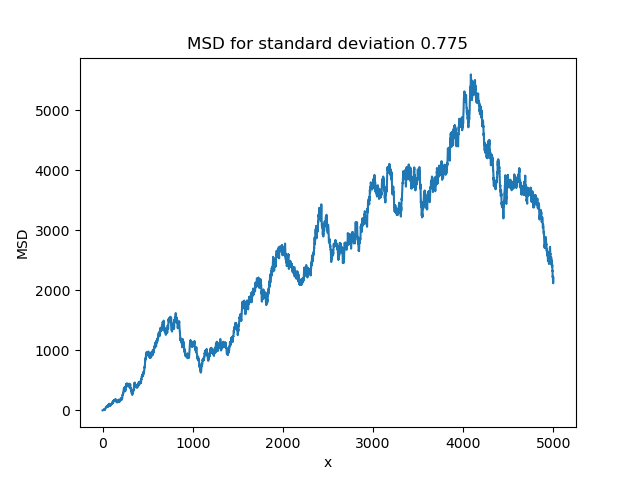

In [7]:
fig, ax = plt.subplots()
ax.plot(msd)
ax.set_title(f"MSD for standard deviation {standard_deviation}")
ax.set_xlabel("x")
ax.set_ylabel("MSD")
# Only save figure to the first replica
fig.savefig(os.path.join(path,"msd.png"))
plt.close()
Image(os.path.join(path,"msd.png"))

In [8]:
# Example of reading signac's file

In [13]:
hf_signac = h5py.File(os.path.join(path, "signac_data.h5"), 'r')

In [14]:
hf_signac.get('positions')

In [11]:
hf_signac.keys()

<KeysViewHDF5 ['msd']>

In [12]:
hf_signac.close()

extras
- Compute radius of gyration
- compute end to end distance
- plot histogram